#### Code for lstm network development. data preparation for lstm can be found in preprocess/seqdata.ipynb

In [48]:
import pandas as pd
import numpy as np
import keras
from math import ceil
import time
import glob,os
import matplotlib.pyplot as plt
import pickle
import pdb
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler


In [72]:
#load data
with open('/home/arash/ProjectVR/cleaneddata/seqdata', 'rb') as f:
    allseqdata = pickle.load(f)

inputseq=allseqdata[0]
ypadded=allseqdata[1]

In [71]:
#load data
with open('/home/arash/ProjectVR/cleaneddata/auxdata', 'rb') as f:
    allauxdata = pickle.load(f) 

In [74]:
allauxdata.shape     
# allauxdata columns' corresponding variables:
#'Snowy','Night', 'One way', 'two way', 'Two way with median','Speed Limit_30.0', 
#'Speed Limit_40.0', 'Speed Limit_50.0','Lane Width_2.5', 'Lane Width_2.75', 'Lane Width_3.0',
#'Mean Arrival Rate_530.0', 'Mean Arrival Rate_750.0',
#'Mean Arrival Rate_1100.0'

(3309, 14)

In [5]:
inputseq.shape

(3309, 102, 5)

In [6]:
ypadded.shape

(3309, 144)

In [ ]:
#####not use scaled measures for now
scaler = MinMaxScaler(feature_range=(0, 1))
Xscaled = scaler.fit_transform(Xpadded)

yscaled = scaler.fit_transform(ypadded)

o1scaled = scaler.fit_transform(o1padded)
o2scaled = scaler.fit_transform(o2padded)
o3scaled = scaler.fit_transform(o3padded)
distscaled = scaler.fit_transform(distpadded)

In [10]:
#check if data is float:
print(ypadded.dtype,inputseq.dtype)

float32 float32


In [75]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = inputseq.shape[2]
n_steps_in=inputseq.shape[1]
n_steps_out=ypadded.shape[1]

In [76]:
# seperate validation data and test set
import random
tst=0.2                 #% if test data
val=0.2                 #% if valid data       
tstsize = int(np.floor(len(inputseq) * tst))
valsize = int(np.floor(len(inputseq) * val))

tstlabel=[]
for i in range(tstsize):
    temp = random.randint(0,inputseq.shape[0]-1)
    tstlabel.append(temp)

Xtest=inputseq[tstlabel]
ytest=ypadded[tstlabel]
auxdatatest = allauxdata[tstlabel]

In [77]:
trnlabel=[i for i in range(inputseq.shape[0]) if i not in tstlabel]
trnsize=len(trnlabel)

Xtrain = inputseq[trnlabel]          #Excluding test set
ytrain = ypadded[trnlabel]
auxdatatrain = allauxdata[trnlabel]

In [78]:
vallabel=[]
for i in range(valsize):
    temp = trnlabel[random.randint(0,trnsize-1)]
    vallabel.append(temp)

Xval=inputseq[vallabel]
yval=ypadded[vallabel]
auxdataval=allauxdata[vallabel]

trainlabel=[i for i in range(Xtrain.shape[0]) if i not in [vallabel]]
Xtrain=Xtrain[trainlabel]
ytrain=ytrain[trainlabel]
auxdatatrain = auxdatatrain[trainlabel]

In [ ]:
# define vanilla lstm model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
history=model.fit(Xtrain, ytrain,
                  epochs=200, verbose=1,batch_size=32,
                  validation_data=(Xval, yval))
                  



# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
#pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# make a prediction
yhat = model.predict(Xval)

Xtrain[0].shape

In [79]:
# define lstm model with aux variables
# sequential input: meant to receive sequence data (inputseq)
# Note that we can name any layer by passing it a "name" argument.
seq_input = Input(shape=(n_steps_in, n_features), dtype='float32', name='seq_input')


# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(50,activation='relu')(seq_input)
auxiliary_output = Dense(n_steps_out, name='aux_output')(lstm_out)
auxiliary_input = Input(shape=(allauxdata.shape[1],), name='aux_input')

In [80]:
x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(n_steps_out, name='main_output')(x)

In [81]:
model = Model(inputs=[seq_input, auxiliary_input], outputs=[main_output, auxiliary_output])


In [82]:
model.compile(optimizer='adam', loss='mse',
              loss_weights=[1., 0.2])

In [86]:
history=model.fit([Xtrain, auxdatatrain], [ytrain, ytrain],
          epochs=50, batch_size=32,validation_data=([Xval, auxdataval],[yval, yval]))

Train on 2718 samples, validate on 661 samples
Epoch 1/50
2718/2718 [==============================] - 3s 1ms/step - loss: 37385.2148 - main_output_loss: 28848.3495 - aux_output_loss: 42684.3238 - val_loss: 26210.6752 - val_main_output_loss: 19657.7969 - val_aux_output_loss: 32764.3922
Epoch 2/50
2718/2718 [==============================] - 3s 960us/step - loss: 10268873.0786 - main_output_loss: 109475.0592 - aux_output_loss: 50796992.1490 - val_loss: 52249.4373 - val_main_output_loss: 25129.2100 - val_aux_output_loss: 135601.1348
Epoch 3/50
2718/2718 [==============================] - 3s 972us/step - loss: 40476.5259 - main_output_loss: 26670.8574 - aux_output_loss: 69028.3425 - val_loss: 45536.2753 - val_main_output_loss: 22568.7716 - val_aux_output_loss: 114837.5166
Epoch 4/50
2718/2718 [==============================] - 3s 968us/step - loss: 56536.8962 - main_output_loss: 27273.4896 - aux_output_loss: 146317.0298 - val_loss: 47430.5464 - val_main_output_loss: 23565.3450 - val_aux_o

2718/2718 [==============================] - 3s 1ms/step - loss: 27595.2427 - main_output_loss: 22293.4223 - aux_output_loss: 26509.1027 - val_loss: 24102.9829 - val_main_output_loss: 19431.2428 - val_aux_output_loss: 23358.7005
Epoch 35/50
2718/2718 [==============================] - 3s 992us/step - loss: 27572.9579 - main_output_loss: 22292.0333 - aux_output_loss: 26404.6224 - val_loss: 24072.9785 - val_main_output_loss: 19419.7530 - val_aux_output_loss: 23266.1261
Epoch 36/50
2718/2718 [==============================] - 3s 1ms/step - loss: 27565.3640 - main_output_loss: 22303.1299 - aux_output_loss: 26311.1699 - val_loss: 24019.1197 - val_main_output_loss: 19385.5069 - val_aux_output_loss: 23168.0623
Epoch 37/50
2718/2718 [==============================] - 3s 971us/step - loss: 27532.9026 - main_output_loss: 22288.8378 - aux_output_loss: 26220.3235 - val_loss: 24015.0770 - val_main_output_loss: 19398.3383 - val_aux_output_loss: 23083.6930
Epoch 38/50
2718/2718 [=====================

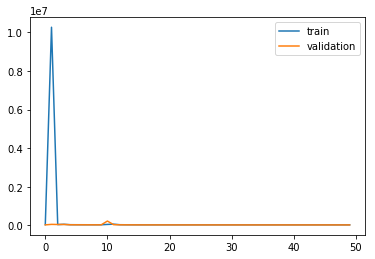

In [87]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
#pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [98]:
# make a prediction
model.predict([Xval,auxdataval])


[array([[ 6.6035028e+02,  6.4569128e+02,  6.5514807e+02, ...,
          4.3764824e-01,  3.6512964e+00, -9.2511791e-01],
        [ 6.6794171e+02,  6.6805518e+02,  6.6219513e+02, ...,
          6.0681862e-01,  3.5338926e+00, -7.3950142e-01],
        [ 6.7107965e+02,  6.6781366e+02,  6.6488287e+02, ...,
          3.0531745e+00,  9.1032572e+00, -2.8419394e+00],
        ...,
        [ 6.6107269e+02,  6.6232263e+02,  6.5562268e+02, ...,
          5.3936523e-01,  2.1913977e+00, -7.4074644e-01],
        [ 6.5626349e+02,  6.4347888e+02,  6.5240222e+02, ...,
          1.3708059e-01,  2.7549608e+00, -6.3255733e-01],
        [ 6.4659467e+02,  6.5045892e+02,  6.4761505e+02, ...,
          2.7854853e+00,  5.0426698e+00, -5.9913993e-03]], dtype=float32),
 array([[653.56024  , 606.751    , 611.7057   , ...,  -9.393611 ,
          -2.6657748, -25.84703  ],
        [783.44714  , 743.3518   , 732.0124   , ...,   8.581197 ,
         -10.054515 ,   2.906241 ],
        [643.4705   , 744.9017   , 862.658    

653.56024